### Credit Default Risk Model

Source: https://www.kaggle.com/code/kabure/predicting-credit-risk-model-pipeline#3.-First-Look-at-the-data:

Biggest Issues:
- Time complexity of training and hyperparameter tunings (Grid -> Random)

What I learned:
- The importance of optimizing time.

In [13]:
import time
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

warnings.simplefilter(action='ignore', category=FutureWarning) # suppress FutureWarnings

#### Step 1: Read and explore

In [3]:
df = pd.read_csv("UCI_Credit_Card.csv")
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


#### Step 2: Pre-process

In [4]:
# split
X = df.drop(['default.payment.next.month'], axis=1)
y = df['default.payment.next.month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# some algos will require standardization
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

#### Step 3: Explore algorithms

In [5]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (24000, 24)
y_train shape: (24000,)
X_test shape: (6000, 24)
y_test shape: (6000,)


In [6]:
# given a model, it fits and returns a list of 10 accuracy scores from diff splits for one model
def cv_scores(model, X_train_std, y_train):
    kfold = KFold(n_splits=10)
    scoring = 'accuracy' #perhaps change to recall?
    cv_result = cross_val_score(model, X_train_std, y_train, cv=kfold, scoring='accuracy')
    return cv_result

In [7]:
rf = RandomForestClassifier()
pred = cv_scores(rf, X_train_std, y_train)
print(pred)

[0.81291667 0.81041667 0.82625    0.80416667 0.80708333 0.81208333
 0.82041667 0.82458333 0.83125    0.82458333]


In [9]:
### instantiate every algorithm
models = []
models.append(('lr', LogisticRegression()))
models.append(('lda', LinearDiscriminantAnalysis()))
models.append(('knn', KNeighborsClassifier()))
models.append(('dtree', DecisionTreeClassifier()))
models.append(('nb', GaussianNB()))
models.append(('rf', RandomForestClassifier(random_state=1)))
models.append(('svm', SVC(gamma='auto')))
models.append(('xgb', XGBClassifier()))

start_time = time.time()

# get the score for each algorithm
model_names = []
model_cvscores = []
for name, model in models:
    model_names.append(name)
    score_list = cv_scores(model, X_train_std, y_train)
    avg_score = score_list.mean()
    model_cvscores.append(avg_score)

end_time = time.time()

# display training time
elapsed_time = end_time - start_time
print("Training time: ", elapsed_time)

Training time:  496.0665137767792


[0.8105833333333333, 0.8116249999999999, 0.7917083333333335, 0.723, 0.7341249999999999, 0.8184166666666666, 0.8199583333333333, 0.8147500000000001]


Text(0.5, 1.0, 'Accuracy of Each Algorithm (Before Std (Blue) vs. After Std (Red) vs. CrossVal (Green))')

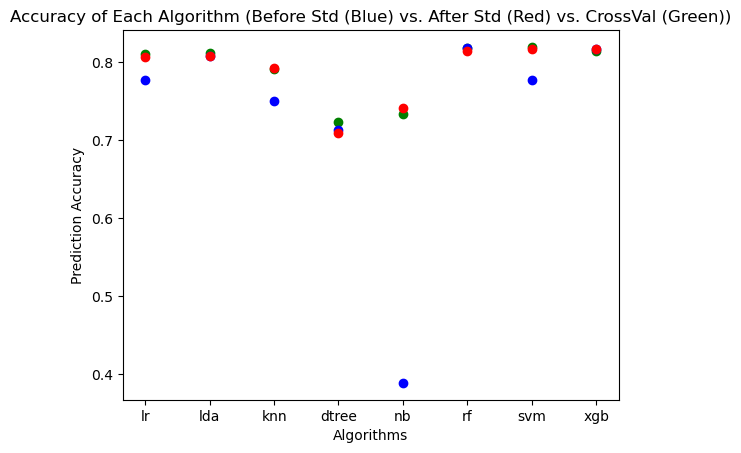

In [11]:
# these are the scores i got before standardiziing the dataset (in blue)
# observe that red is either greater than or equal to blue (clearly standardizing helps)
# green doesn't have to be better, we just know it's more accurate
scores_b4_std = [0.7771666666666667, 0.8078333333333333, 0.7508333333333334, 0.7128333333333333, 0.3888333333333333, 0.8188333333333333, 0.7771666666666667, 0.8171666666666667]
scores_std_not_cv = [0.8076666666666666, 0.8078333333333333, 0.793, 0.7091666666666666, 0.742, 0.8153333333333334, 0.8176666666666667, 0.8171666666666667]

print(model_cvscores) # we see that green is pre much equal to red
plt.scatter(model_names, model_cvscores, color='green')
plt.scatter(model_names, scores_b4_std, color='blue')
plt.scatter(model_names, scores_std_not_cv, color='red')
plt.xlabel("Algorithms")
plt.ylabel("Prediction Accuracy")
plt.title("Accuracy of Each Algorithm (Before Std (Blue) vs. After Std (Red) vs. CrossVal (Green))")

# let's go with the following algorithms: lr, lda, rf, svm, xgb

#### Step 4: Tune hyperparameters
After determining the optimal algorithms, let's tune the hyperparameters using grid search.

In [21]:
# instantiate the rest
lr = LogisticRegression()
lda = LinearDiscriminantAnalysis()
knn = KNeighborsClassifier()
dtree = DecisionTreeClassifier()
nb = GaussianNB()
rf = RandomForestClassifier()
svm = SVC(gamma='auto')
xgb = XGBClassifier()

In [16]:
# set hyperparameters for Random Forest
start_time = time.time()

param_dist = {"max_depth": [3, 5, 7, 10, None], # Maximum depth of the tree
              "n_estimators": [5, 10, 25, 50, 150], # Number of trees in the forest
              "max_features": [4, 7, 15, 20]} # Number of features to consider for the best split
grid_search = RandomizedSearchCV(rf, param_distributions=param_dist, n_iter=5, cv=5, scoring="accuracy", verbose=1)
grid_search.fit(X_train_std, y_train)

end_time = time.time()

elapsed_time = end_time - start_time
print("Tuning time: ", elapsed_time)
print("Best possible score: ", grid_search.best_score_)
print("Optimal parameters: ", grid_search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Tuning time:  284.8582880496979
Best possible score:  0.821125
Optimal parameters:  {'n_estimators': 50, 'max_features': 15, 'max_depth': 7}


In [24]:
# set hyperparameters for XGBoost
param_dist = {
    'learning_rate': [0.001, 0.01, 0.1],  # Learning rate
    'n_estimators': [100, 200, 300],  # Number of boosting rounds
    'max_depth': [3, 5, 7],  # Maximum depth of a tree
    'subsample': [0.8, 0.9],  # Subsample ratio of the training instance
    'colsample_bytree': [0.8, 0.9],  # Subsample ratio of columns when constructing each tree
}
grid_search = RandomizedSearchCV(xgb, param_distributions=param_dist, n_iter=5, cv=5, scoring="accuracy", verbose=1)
grid_search.fit(X_train_std, y_train)

print("Best possible score: ", grid_search.best_score_)
print("Optimal parameters: ", grid_search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best possible score:  0.821875
Optimal parameters:  {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


In [23]:
# set hyperparameters for Linear Discriminant Analysis
param_grid = {
    'solver': ['svd', 'lsqr', 'eigen'],  # Solver for singular value decomposition
}
grid_search = GridSearchCV(lda, param_grid=param_grid, cv=5, scoring="accuracy", verbose=1)
grid_search.fit(X_train_std, y_train)

print("Best possible score: ", grid_search.best_score_)
print("Optimal parameters: ", grid_search.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best possible score:  0.8118333333333332
Optimal parameters:  {'solver': 'svd'}


In [27]:
# set hyperparameters for Logistic Regression
param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l1', 'l2'],  # Type of regularization ('l1' for Lasso, 'l2' for Ridge)
    'solver': ['liblinear'],  # Solver algorithm
}
grid_search = RandomizedSearchCV(lr, param_distributions=param_dist, cv=5, scoring="accuracy", verbose=1)
grid_search.fit(X_train_std, y_train)

print("Best possible score: ", grid_search.best_score_)
print("Optimal parameters: ", grid_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best possible score:  0.8103333333333333
Optimal parameters:  {'solver': 'liblinear', 'penalty': 'l2', 'C': 100}


#### Step 5: Fit with the tuned parameters

In [29]:
# run xgb
xgb_tuned = XGBClassifier(subsample=0.8, n_estimators=300, max_depth=5, learning_rate=0.01, colsample_bytree=0.8, random_state=1)
xgb_tuned.fit(X_train_std, y_train)
y_pred = xgb_tuned.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print("Accuracy: ", accuracy)
print(report)

Accuracy:  0.8123333333333334
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4663
           1       0.72      0.26      0.38      1337

    accuracy                           0.81      6000
   macro avg       0.77      0.62      0.64      6000
weighted avg       0.80      0.81      0.78      6000

